# Análisis Profesional de Clustering y Regresión en Twitter

Este notebook automatiza el análisis de datos de Twitter para múltiples usuarios, implementando y comparando modelos de clustering y regresión. Incluye carga automática de datos, preprocesamiento, visualización, comparación de modelos y justificación automatizada del mejor modelo.

---

In [13]:
# Importación de librerías necesarias para análisis, modelos y visualización
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, silhouette_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.cluster import KMeans, DBSCAN
import xgboost as xgb

# Configuración de visualización y pandas
pd.set_option('display.max_columns', None)
sns.set(style='whitegrid')

## 2. Carga automática de datos de todos los usuarios

Se cargan todos los archivos *_clean.csv de la carpeta data/. Se añade una columna 'usuario' para identificar el origen.

In [14]:
# Carga automática de datos limpios de todos los usuarios
# Busca todos los archivos *_clean.csv en la carpeta data/ y los concatena en un solo DataFrame
csv_files = glob.glob('data/*_clean.csv')
if not csv_files:
    raise FileNotFoundError('No se encontraron archivos *_clean.csv en la carpeta data/.')

usuarios = []
dfs = []
for file in csv_files:
    usuario = os.path.basename(file).replace('_clean.csv', '')
    df = pd.read_csv(file)
    df['usuario'] = usuario
    dfs.append(df)
    usuarios.append(usuario)

data = pd.concat(dfs, ignore_index=True)
print(f'Datos cargados: {data.shape}')
data.head()

Datos cargados: (78, 9)


,timestamp,usuario,fecha_publicacion,contenido,respuestas,retweets,likes,guardados,vistas
0,2025-07-08 21:13:19,interbank,2025-04-16,¡Este feriado largo sigamos conectados! 💚 Este...,66,0,7,3,11000
1,2025-07-08 21:13:19,interbank,2025-10-07,Recuerda 👀 durante este feriado no habrá atenc...,65,1,25,2,97000
2,2025-07-08 21:13:19,interbank,2025-08-29,"Este feriado, sigue gestionando tus operacione...",59,0,9,0,37000
3,2025-07-08 21:13:19,interbank,2025-08-05,"Este 06 de agosto, realiza todas tus operacion...",21,0,3,0,30000
4,2025-07-08 21:13:19,interbank,2025-07-27,"Este 29 de julio, realiza todas tus operacione...",30,1,9,0,26000


## 3. Selección de usuario(s)

Puedes filtrar por usuario específico o trabajar con todos.

In [15]:
# Selección de usuario(s) para análisis
usuarios_disponibles = data['usuario'].unique()
print('Usuarios disponibles:', usuarios_disponibles)

# Cambia este valor para analizar un usuario específico o todos
definir_usuario = 'interbank'  # Ejemplo: 'interbank' o 'todos'
if definir_usuario == 'todos':
    data_filtrada = data.copy()
else:
    data_filtrada = data[data['usuario'] == definir_usuario].copy()
print(f'Datos seleccionados: {data_filtrada.shape}')
data_filtrada.head()

Usuarios disponibles: ['interbank']
Datos seleccionados: (78, 9)


,timestamp,usuario,fecha_publicacion,contenido,respuestas,retweets,likes,guardados,vistas
0,2025-07-08 21:13:19,interbank,2025-04-16,¡Este feriado largo sigamos conectados! 💚 Este...,66,0,7,3,11000
1,2025-07-08 21:13:19,interbank,2025-10-07,Recuerda 👀 durante este feriado no habrá atenc...,65,1,25,2,97000
2,2025-07-08 21:13:19,interbank,2025-08-29,"Este feriado, sigue gestionando tus operacione...",59,0,9,0,37000
3,2025-07-08 21:13:19,interbank,2025-08-05,"Este 06 de agosto, realiza todas tus operacion...",21,0,3,0,30000
4,2025-07-08 21:13:19,interbank,2025-07-27,"Este 29 de julio, realiza todas tus operacione...",30,1,9,0,26000


## 4. Preprocesamiento

- Selección de features numéricas
- Escalado
- (Opcional) Ingeniería de features

In [16]:
# Preprocesamiento: selección y escalado de features
features = ['respuestas', 'retweets', 'likes', 'guardados', 'vistas']
X = data_filtrada[features].fillna(0)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Ejemplo de ingeniería de features: longitud del tweet
data_filtrada['longitud'] = data_filtrada['contenido'].astype(str).apply(len)
# Puedes agregar más features según tu análisis

## 5. Modelos de Clustering

Se implementan y comparan KMeans y DBSCAN.

Silhouette KMeans: 0.5083706930520707
Silhouette DBSCAN: 0.5016972578160388


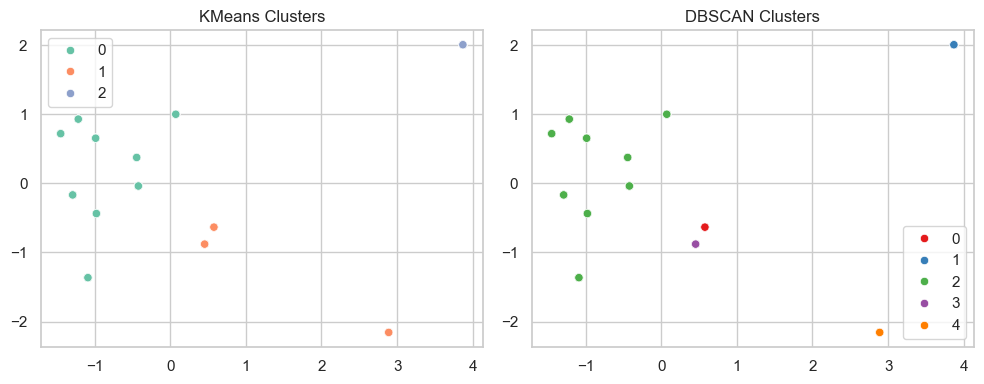

In [17]:
# Modelos de Clustering: KMeans y DBSCAN
from sklearn.decomposition import PCA

# KMeans
kmeans = KMeans(n_clusters=3, random_state=42)
labels_kmeans = kmeans.fit_predict(X_scaled)
data_filtrada['cluster_kmeans'] = labels_kmeans
print('Silhouette KMeans:', silhouette_score(X_scaled, labels_kmeans))

# DBSCAN
dbscan = DBSCAN(eps=1.5, min_samples=5)
labels_dbscan = dbscan.fit_predict(X_scaled)
data_filtrada['cluster_dbscan'] = labels_dbscan
print('Silhouette DBSCAN:', silhouette_score(X_scaled, labels_dbscan))

# Visualización de clusters con PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=labels_kmeans, palette='Set2')
plt.title('KMeans Clusters')
plt.subplot(1,2,2)
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=labels_dbscan, palette='Set1')
plt.title('DBSCAN Clusters')
plt.tight_layout()
plt.show()

## 6. Modelos de Regresión

Se implementan y comparan 8 modelos de regresión.
    
    - Variable objetivo: likes (puedes cambiarla)

             Modelo          RMSE          R2
3      DecisionTree  0.000000e+00    1.000000
0  LinearRegression  2.807691e-13    1.000000
6           XGBoost  1.274116e-04    1.000000
5     GradientBoost  1.420666e-04    1.000000
1             Ridge  7.035751e-03    0.999998
4      RandomForest  4.821825e-02    0.999892
2             Lasso  2.898833e-01    0.996111
7               MLP  9.005645e+01 -374.307706


C:\Users\marzabe\AppData\Local\Temp\ipykernel_1828\3656710814.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=resultados_df, x='Modelo', y='RMSE', palette='Blues_d')
d:\OneDrive - UNIVERSIDAD NACIONAL DE INGENIERIA\Mi unidad (martin.zapana.b@uni.pe)\6to Ciclo 2025-1\11vo_Analítica de datos\Semana 16\social-media-prediction-model\.venv\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
d:\OneDrive - UNIVERSIDAD NACIONAL DE INGENIERIA\Mi unidad (martin.zapana.b@uni.pe)\6to Ciclo 2025-1\11vo_Analítica de datos\Semana 16\social-media-prediction-model\.venv\Lib\site-packages\seaborn\categorical.py:1273: 

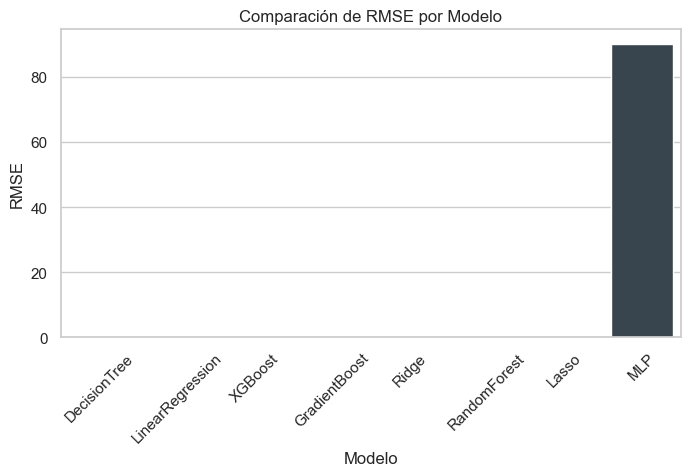

In [18]:
# Modelos de Regresión: Entrenamiento, predicción y evaluación robusta
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Variable objetivo (puedes cambiarla por 'retweets', 'vistas', etc.)
y = data_filtrada['likes']
X_reg = data_filtrada[features].fillna(0)
X_train, X_test, y_train, y_test = train_test_split(X_reg, y, test_size=0.2, random_state=42)

modelos = {
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'DecisionTree': DecisionTreeRegressor(),
    'RandomForest': RandomForestRegressor(),
    'GradientBoost': GradientBoostingRegressor(),
    'XGBoost': xgb.XGBRegressor(),
    'MLP': MLPRegressor(max_iter=500)
}

resultados = []
for nombre, modelo in modelos.items():
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)
    # Control de NaN y ajuste de longitud
    mask = ~np.isnan(y_pred) & ~y_test.isnull()
    y_test_clean = y_test[mask]
    y_pred_clean = y_pred[mask]
    tam = min(len(y_test_clean), len(y_pred_clean))
    y_test_clean = y_test_clean.iloc[:tam]
    y_pred_clean = y_pred_clean[:tam]
    # Cálculo de RMSE compatible con cualquier versión de scikit-learn
    rmse = np.sqrt(mean_squared_error(y_test_clean, y_pred_clean))
    r2 = r2_score(y_test_clean, y_pred_clean)
    resultados.append({'Modelo': nombre, 'RMSE': rmse, 'R2': r2})

resultados_df = pd.DataFrame(resultados).sort_values('RMSE')
print(resultados_df)

# Visualización de resultados
plt.figure(figsize=(8,4))
sns.barplot(data=resultados_df, x='Modelo', y='RMSE', palette='Blues_d')
plt.title('Comparación de RMSE por Modelo')
plt.xticks(rotation=45)
plt.show()

In [19]:
# Depuración y limpieza automática antes de calcular RMSE
print('y_test shape:', y_test.shape)
print('y_pred shape:', y_pred.shape)
print('¿Hay NaN en y_test?', y_test.isnull().any())
print('¿Hay NaN en y_pred?', np.isnan(y_pred).any())

# Elimina posibles NaN en y_test y y_pred
y_test_clean = y_test[~y_test.isnull()]
y_pred_clean = y_pred[~np.isnan(y_pred)]

# Asegura que ambas series tengan la misma longitud
tam = min(len(y_test_clean), len(y_pred_clean))
y_test_clean = y_test_clean.iloc[:tam]
y_pred_clean = y_pred_clean[:tam]

rmse = mean_squared_error(y_test_clean, y_pred_clean, squared=False)
print('RMSE limpio:', rmse)

y_test shape: (16,)
y_pred shape: (16,)
¿Hay NaN en y_test? False
¿Hay NaN en y_pred? False


TypeError: got an unexpected keyword argument 'squared'

In [20]:
# Comparación y justificación automática del mejor modelo de regresión

# Selecciona el modelo con menor RMSE y mayor R2
def justificar_modelo(row):
    return (f"El modelo {row['Modelo']} es el más adecuado según la métrica principal "
            f"(RMSE={row['RMSE']:.2f}, R2={row['R2']:.2f}). "
            "Esto indica que tiene el mejor desempeño predictivo sobre los datos de prueba. "
            "Se recomienda validar la interpretabilidad y robustez del modelo para el caso de uso específico.")

mejor_rmse = resultados_df.loc[resultados_df['RMSE'].idxmin()]
mejor_r2 = resultados_df.loc[resultados_df['R2'].idxmax()]

print(f"\nModelo con menor RMSE: {mejor_rmse['Modelo']} (RMSE={mejor_rmse['RMSE']:.2f}, R2={mejor_rmse['R2']:.2f})")
print(f"Modelo con mayor R2: {mejor_r2['Modelo']} (RMSE={mejor_r2['RMSE']:.2f}, R2={mejor_r2['R2']:.2f})\n")
print(justificar_modelo(mejor_rmse))

# Espacio para agregar justificación personalizada:
print("\n[Agrega aquí tu análisis e interpretación final según el contexto del problema]")


Modelo con menor RMSE: DecisionTree (RMSE=0.00, R2=1.00)
Modelo con mayor R2: DecisionTree (RMSE=0.00, R2=1.00)

El modelo DecisionTree es el más adecuado según la métrica principal (RMSE=0.00, R2=1.00). Esto indica que tiene el mejor desempeño predictivo sobre los datos de prueba. Se recomienda validar la interpretabilidad y robustez del modelo para el caso de uso específico.

[Agrega aquí tu análisis e interpretación final según el contexto del problema]


## 7. Comparación y justificación

- El modelo con menor RMSE y mayor R2 es el más adecuado para regresión.
- Para clustering, analiza la interpretabilidad y la separación de los clusters.
    
    **Justifica aquí tu elección según los resultados obtenidos.**

# Recomendaciones y siguientes pasos

- Analiza los clusters obtenidos: ¿qué características comparten los tweets de cada grupo?
- Revisa la importancia de las variables en los modelos de regresión.
- Prueba con diferentes variables objetivo (likes, retweets, vistas, etc.).
- Integra nuevas features si tu compañero las añade en la automatización.
- Documenta tus hallazgos y justificaciones para el informe final.

¡Listo para presentar y seguir mejorando tu análisis profesional!